In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
import PIL
from IPython.display import display
from PIL import Image
import pathlib
import csv

# Подготовка данных

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install patool

     |████████████████████████████████| 81kB 2.7MB/s 


In [0]:
import patoolib
patoolib.extract_archive("/content/drive/My Drive/celeba_glasses_-1.zip")

patool: Extracting /content/drive/My Drive/celeba_glasses_-1.zip ...
patool: running /usr/bin/7z x -o./Unpack_vin4fryw -- "/content/drive/My Drive/celeba_glasses_-1.zip"
patool: ... /content/drive/My Drive/celeba_glasses_-1.zip extracted to `celeba_glasses_-1'.


'celeba_glasses_-1'

In [0]:
patoolib.extract_archive("/content/drive/My Drive/celeba_glasses_+1.zip")

patool: Extracting /content/drive/My Drive/celeba_glasses_+1.zip ...
patool: running /usr/bin/7z x -o./Unpack_gnbvc0gs -- "/content/drive/My Drive/celeba_glasses_+1.zip"
patool: ... /content/drive/My Drive/celeba_glasses_+1.zip extracted to `celeba_glasses_+1'.


'celeba_glasses_+1'

In [0]:
!ls celeba_glasses_+1

In [0]:
!ls

celeba_glasses_-1  celeba_glasses_+1  drive  sample_data  temp


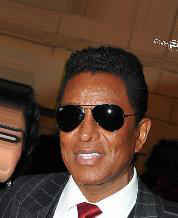

In [0]:
arr = image.load_img('celeba_glasses_+1/013990.jpg')
display(arr)

In [0]:
from os import listdir
print(len(listdir('celeba_glasses_+1')), len(listdir('celeba_glasses_-1')))

2058 1880


In [0]:
%%bash
mkdir train
mkdir test
mkdir valid

In [0]:
%%bash
mkdir train/glasses
mkdir train/noglasses

In [0]:
%%bash
mkdir test/glasses
mkdir test/noglasses

In [0]:
%%bash
mkdir valid/glasses
mkdir valid/noglasses

In [0]:
!ls

celeba_glasses_-1  celeba_glasses_+1  drive  sample_data  test	train  valid


In [0]:
coef_train = 0.7
coef_test = 0.2
coef_valid = 0.1
value_glasses = len(listdir('celeba_glasses_+1'))
value_noglasses = len(listdir('celeba_glasses_-1'))

In [0]:
import shutil
import os

file_names_glasses = listdir('celeba_glasses_+1')
file_names_noglasses = listdir('celeba_glasses_-1')


for i in range(0, int(coef_train*value_glasses)):
    shutil.copy(os.path.join('celeba_glasses_+1', file_names_glasses[i]), 'train/glasses')

for i in range(int(coef_train*value_glasses), int((coef_train+coef_test)*value_glasses)):
    shutil.copy(os.path.join('celeba_glasses_+1', file_names_glasses[i]), 'test/glasses')

for i in range(int((coef_train+coef_test)*value_glasses), int(value_glasses)):
    shutil.copy(os.path.join('celeba_glasses_+1', file_names_glasses[i]), 'valid/glasses')

In [0]:
for i in range(0, int(coef_train*value_noglasses)):
    shutil.copy(os.path.join('celeba_glasses_-1', file_names_noglasses[i]), 'train/noglasses')

for i in range(int(coef_train*value_noglasses), int((coef_train+coef_test)*value_noglasses)):
    shutil.copy(os.path.join('celeba_glasses_-1', file_names_noglasses[i]), 'test/noglasses')

for i in range(int((coef_train+coef_test)*value_noglasses), int(value_noglasses)):
    shutil.copy(os.path.join('celeba_glasses_-1', file_names_noglasses[i]), 'valid/noglasses')

In [0]:
print(len(listdir('train/glasses')),len(listdir('test/glasses')),len(listdir('valid/glasses')))

1440 412 206


In [0]:
print(len(listdir('train/noglasses')),len(listdir('test/noglasses')),len(listdir('valid/noglasses')))

1316 375 189


# Начинаем строить модель

In [0]:
# Размеры изображения
img_width, img_height = 224, 224
# Размерности тензоров
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 50

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

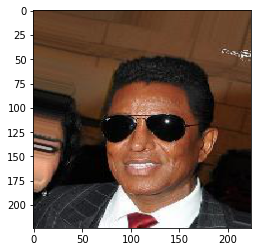

In [0]:
img_path = 'celeba_glasses_+1/013990.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

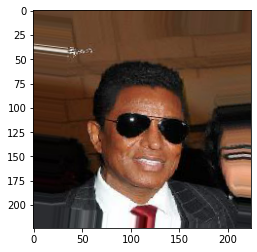

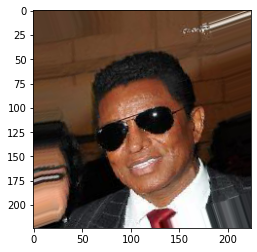

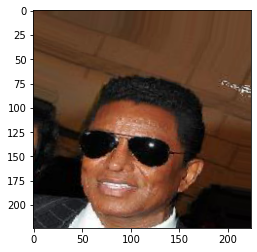

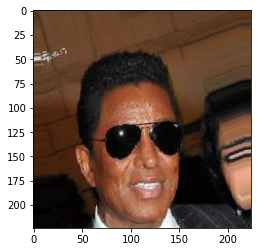

In [0]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [0]:
train_generator = datagen.flow_from_directory(
    'train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2756 images belonging to 2 classes.


In [0]:
valid_generator = datagen.flow_from_directory(
    'valid',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 395 images belonging to 2 classes.


In [0]:
train_generator.class_indices

{'glasses': 0, 'noglasses': 1}

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_NN = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
vgg16_NN.trainable = False

In [0]:
model = Sequential()
model.add(vgg16_NN)
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Reshape((7*7*64,)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 64)          16448     
_________________________________________________________________
reshape (Reshape)            (None, 3136)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
lr = 1e-4
model.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=lr), 
                      metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=3)

In [0]:
import time
start_all_time = time.time()
history = model.fit_generator(
                      train_generator,
                      steps_per_epoch=int(coef_train*value_glasses) // batch_size,
                      epochs=5,
                      validation_data = valid_generator,
                      validation_steps = int(coef_valid*value_glasses) // batch_size,
                      callbacks=[early_stopping_callback],
                      verbose=1)
print (f'Обучилась за: {time.time() - start_all_time}')

Epoch 1/5
28/28 [==============================] - 822s 29s/step - loss: 0.7238 - acc: 0.5393 - val_loss: 0.6693 - val_acc: 0.6250
Epoch 2/5
28/28 [==============================] - 790s 28s/step - loss: 0.6549 - acc: 0.6202 - val_loss: 0.6186 - val_acc: 0.6450
Epoch 3/5
28/28 [==============================] - 810s 29s/step - loss: 0.6456 - acc: 0.6293 - val_loss: 0.5716 - val_acc: 0.7550
Epoch 4/5
28/28 [==============================] - 788s 28s/step - loss: 0.5823 - acc: 0.7220 - val_loss: 0.5401 - val_acc: 0.7500
Epoch 5/5
28/28 [==============================] - 790s 28s/step - loss: 0.5365 - acc: 0.7611 - val_loss: 0.4891 - val_acc: 0.8100
Обучилась за: 4000.290368795395
